In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
names = open('data/names.txt', 'r').read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
letters = sorted(list(set(''.join(names))))
SoS = '<.>'
letters = [SoS] + letters 
letter2index = {l:i for i, l in enumerate(letters)}
index2letter = {i:l for l, i in letter2index.items()}
print(index2letter)

{0: '<.>', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [4]:
import random

def build_dataset(names, block_size):
    X, Y = [], []

    for name in names:
        context = [letter2index[SoS]] * block_size
        for letter in (list(name) + [SoS]):
            idx = letter2index[letter]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

def shuffle_data(X, Y):
    r_idx = list(range(X.size(0)))
    random.shuffle(r_idx)
    return X[r_idx], Y[r_idx]

block_size = 3

random.seed(42)
X, Y = shuffle_data(*build_dataset(names, block_size))
n1 = int(0.8 * X.size(0))
n2 = int(0.9 * X.size(0))
X_train, Y_train = X[:n1], Y[:n1]
print("training:", X_train.shape, Y_train.shape)
X_val, Y_val = X[n1:n2], Y[n1:n2]
print("validation:", X_val.shape, Y_val.shape)
X_test, Y_test = X[n2:], Y[n2:]
print("test:", X_test.shape, Y_test.shape)


torch.Size([228146, 3]) torch.Size([228146])
training: torch.Size([182516, 3]) torch.Size([182516])
validation: torch.Size([22815, 3]) torch.Size([22815])
test: torch.Size([22815, 3]) torch.Size([22815])


In [5]:
def init_model(vocab_size, block_size, embedding_size, hidden_size, g):
    C = torch.randn((vocab_size, embedding_size), generator=g)
    W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g)
    b1 = torch.randn((1, hidden_size), generator=g)
    W2 = torch.randn((hidden_size, vocab_size), generator=g)
    b2 = torch.randn((1, vocab_size), generator=g)

    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True

    return {
        "C": C,
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "parameters": parameters
    }

def forward(model_dict, X_batch, Y_batch):
    C, W1, b1, W2, b2 = model_dict["C"], model_dict["W1"], model_dict["b1"], model_dict["W2"], model_dict["b2"]
    embedded = C[X_batch]
    hidden = torch.tanh(embedded.view(-1, W1.size(0)) @ W1 + b1)
    logits = hidden @ W2 + b2
    nl_loss = F.cross_entropy(logits, Y_batch)
    return nl_loss, logits.detach()

def backprop(model_dict, loss, lr):
    parameters = model_dict["parameters"]
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data -= lr * p.grad
    return loss.item()

def random_batch(X, Y, batch_size, g):
    batch_idx = torch.randint(0, X.size(0), (batch_size, ), generator=g)
    return X[batch_idx], Y[batch_idx]


vocab_size = len(index2letter)
embedding_size = 10
hidden_size = 200
g = torch.Generator().manual_seed(2147483647)
model_dict = init_model(vocab_size, block_size, embedding_size, hidden_size, g)

print(sum(p.nelement() for p in model_dict["parameters"]))

11897


In [6]:
def train_model(model_dict, n_steps, batch_size, g):
    losses = []

    for i in range(n_steps):
        X_batch, Y_batch = random_batch(X_train, Y_train, batch_size, g=g)
        nl_loss, _ = forward(model_dict, X_batch, Y_batch)
        lr = 0.1 if i < 10000 else 0.01
        loss_val = backprop(model_dict, nl_loss, lr=lr)
        losses.append(loss_val)
    
    return model_dict, losses


batch_size = 32
n_steps = 100000
model_dict, losses = train_model(model_dict, n_steps=n_steps, batch_size=batch_size, g=g)
print(losses[-2:])

[1.873566746711731, 2.4040610790252686]


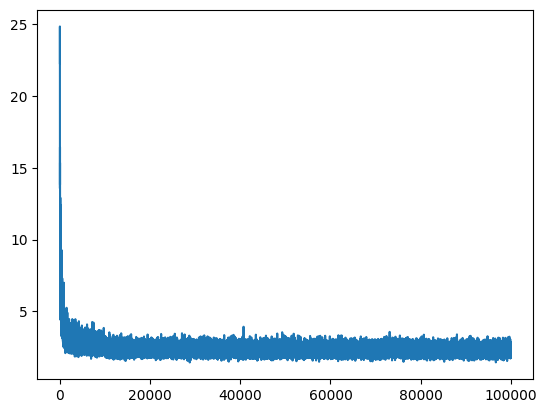

In [7]:
plt.plot(losses)

In [8]:
datasets = {
    "train": (X_train, Y_train),
    "val": (X_val, Y_val),
    "test": (X_test, Y_test)
}

In [9]:
@torch.no_grad()
def split_loss(model_dict, datasets, data_name):
    x, y = datasets[data_name]
    loss, _ = forward(model_dict, x, y)
    print(data_name, loss.item())

split_loss(model_dict, datasets, data_name='train')
split_loss(model_dict, datasets, data_name='val')

train 2.273594379425049
val 2.298309087753296


In [10]:
@torch.no_grad()
def sampling(model_dict, g, n_samples):
    for _ in range(n_samples):
        outputs = []
        context = [letter2index[SoS]] * block_size
        while True:
            _, logits = forward(model_dict, torch.tensor(context), torch.tensor([0]))
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
            if index2letter[ix] == SoS:
                break
            outputs.append(index2letter[ix])
            context = context[1:] + [ix]
        print(''.join(outputs))


g = torch.Generator().manual_seed(2147483647 + 10)
sampling(model_dict, g, 10)


carpah
qui
hari
kemliigenty
halaysa
jazhuen
delyah
jareei
nellara
chaiivia


# Observations

## the loss at initialization is very high: the softmax function

In [11]:
logist = torch.tensor([1.0,1.0,1.0,1.0,1.0,1.0])
y = torch.tensor(0)
F.cross_entropy(logist, y)

tensor(1.7918)

In [12]:
logist = torch.tensor([1.0,1.0,1.0,1.0,10.0,100.0])
y = torch.tensor(0)
F.cross_entropy(logist, y)

tensor(99.)

In [13]:
logist = torch.tensor([0.01,0.01,0.01,0.01,0.1,1.0])
y = torch.tensor(0)
F.cross_entropy(logist, y)

tensor(2.0523)

In [14]:
def init_model(vocab_size, block_size, embedding_size, hidden_size, g):
    C = torch.randn((vocab_size, embedding_size), generator=g)
    W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g)
    b1 = torch.randn((1, hidden_size), generator=g)
    W2 = torch.randn((hidden_size, vocab_size), generator=g) * 0.01
    b2 = torch.randn((1, vocab_size), generator=g) * 0.0

    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True

    return {
        "C": C,
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "parameters": parameters
    }

In [16]:
model_dict = init_model(vocab_size, block_size, embedding_size, hidden_size, g)
loss, logits = forward(model_dict, X_train[:batch_size], Y_train[:batch_size])
print(logits[0])
print(loss)

tensor([-0.0208,  0.0384, -0.0547,  0.1528, -0.0619, -0.1271, -0.0914,  0.0906,
        -0.0264, -0.0197,  0.0076, -0.2960,  0.0492, -0.1932, -0.1366,  0.0214,
         0.1239,  0.0333,  0.0778,  0.0801,  0.1704,  0.2353,  0.0693, -0.1878,
         0.2725, -0.1420,  0.1337])
tensor(3.3388, grad_fn=<NllLossBackward0>)


In [39]:
def forward(model_dict, X_batch, Y_batch):
    C, W1, b1, W2, b2 = model_dict["C"], model_dict["W1"], model_dict["b1"], model_dict["W2"], model_dict["b2"]
    embedded = C[X_batch]
    hidden = torch.tanh(embedded.view(-1, W1.size(0)) @ W1 + b1)
    logits = hidden @ W2 + b2
    nl_loss = F.cross_entropy(logits, Y_batch)
    return nl_loss, hidden.detach(), logits.detach()


In [40]:
model_dict = init_model(vocab_size, block_size, embedding_size, hidden_size, g)
loss, hidden, logits = forward(model_dict, X_train[:batch_size], Y_train[:batch_size])
print(logits[0])
print(loss)

tensor([ 0.0055, -0.1295, -0.0898,  0.0584,  0.0117,  0.0614,  0.1589,  0.0173,
         0.0726,  0.0239, -0.0550, -0.1765,  0.2418,  0.0231,  0.0530, -0.1917,
        -0.0097,  0.0609, -0.0777,  0.0734, -0.0310,  0.0823,  0.0869, -0.0150,
         0.0024, -0.0011, -0.0206])
tensor(3.2955, grad_fn=<NllLossBackward0>)


In [41]:
hidden

tensor([[-0.9788,  0.9625,  0.3494,  ...,  0.4753,  0.3143, -0.8375],
        [ 0.0317, -0.9878, -0.7769,  ...,  0.1544, -0.9830, -0.8916],
        [-0.8025, -0.4405, -0.2964,  ...,  0.9401,  0.8835, -0.7694],
        ...,
        [ 0.9065,  0.9932, -0.4024,  ...,  0.9598,  0.1916, -0.9996],
        [ 0.7304, -0.9912, -0.8907,  ...,  0.4394, -0.9429, -0.9430],
        [-0.0176, -0.9593, -0.3596,  ...,  0.7783, -0.9494, -0.8178]])

(array([1177.,  355.,  256.,  188.,  165.,  156.,  142.,  135.,  137.,
         112.,  116.,   81.,   99.,  107.,   97.,  107.,  100.,  111.,
         125.,  117.,  103.,  110.,  119.,  137.,  145.,  168.,  202.,
         227.,  357.,  949.]),
 array([-9.99998868e-01, -9.33332300e-01, -8.66665733e-01, -7.99999166e-01,
        -7.33332598e-01, -6.66666031e-01, -5.99999464e-01, -5.33332896e-01,
        -4.66666329e-01, -3.99999762e-01, -3.33333194e-01, -2.66666627e-01,
        -2.00000060e-01, -1.33333492e-01, -6.66669250e-02, -3.57627869e-07,
         6.66662097e-02,  1.33332777e-01,  1.99999344e-01,  2.66665912e-01,
         3.33332479e-01,  3.99999046e-01,  4.66665614e-01,  5.33332181e-01,
         5.99998748e-01,  6.66665316e-01,  7.33331883e-01,  7.99998450e-01,
         8.66665018e-01,  9.33331585e-01,  9.99998152e-01]),
 <BarContainer object of 30 artists>)

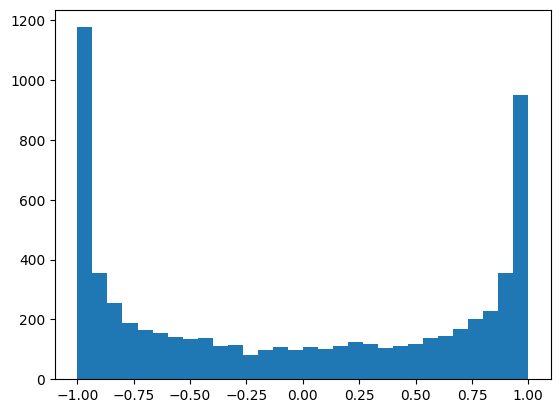

In [42]:
plt.hist(hidden.view(-1).tolist(), 30)

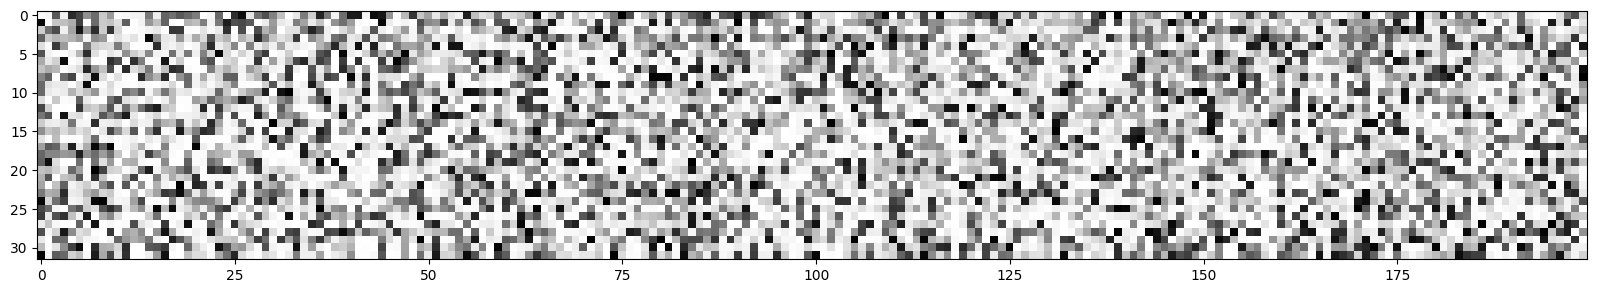

In [43]:
plt.figure(figsize=(20, 10))
plt.imshow(hidden.abs(), cmap='gray', interpolation='nearest')

In [44]:
def init_model(vocab_size, block_size, embedding_size, hidden_size, g):
    C = torch.randn((vocab_size, embedding_size), generator=g)
    W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g) * 0.01
    b1 = torch.randn((1, hidden_size), generator=g) * 0
    W2 = torch.randn((hidden_size, vocab_size), generator=g) * 0.01
    b2 = torch.randn((1, vocab_size), generator=g) * 0.0

    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True

    return {
        "C": C,
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "parameters": parameters
    }

In [45]:
model_dict = init_model(vocab_size, block_size, embedding_size, hidden_size, g)
loss, hidden, logits = forward(model_dict, X_train[:batch_size], Y_train[:batch_size])
print(logits[0])
print(loss)

tensor([ 0.0041, -0.0090,  0.0038, -0.0105,  0.0061,  0.0017,  0.0050,  0.0047,
         0.0064,  0.0052, -0.0054, -0.0022,  0.0033,  0.0046, -0.0009,  0.0062,
         0.0016, -0.0064, -0.0019, -0.0054,  0.0015, -0.0020, -0.0047, -0.0071,
         0.0038,  0.0012, -0.0016])
tensor(3.2953, grad_fn=<NllLossBackward0>)


(array([  1.,   2.,   2.,   9.,  11.,  31.,  47.,  59.,  96., 144., 247.,
        243., 366., 481., 564., 591., 615., 605., 489., 451., 388., 264.,
        244., 176., 110.,  69.,  49.,  22.,  13.,  11.]),
 array([-0.23482937, -0.22057382, -0.20631827, -0.19206273, -0.17780718,
        -0.16355163, -0.14929608, -0.13504054, -0.12078499, -0.10652944,
        -0.0922739 , -0.07801835, -0.0637628 , -0.04950725, -0.03525171,
        -0.02099616, -0.00674061,  0.00751493,  0.02177048,  0.03602603,
         0.05028157,  0.06453712,  0.07879267,  0.09304822,  0.10730376,
         0.12155931,  0.13581486,  0.1500704 ,  0.16432595,  0.1785815 ,
         0.19283704]),
 <BarContainer object of 30 artists>)

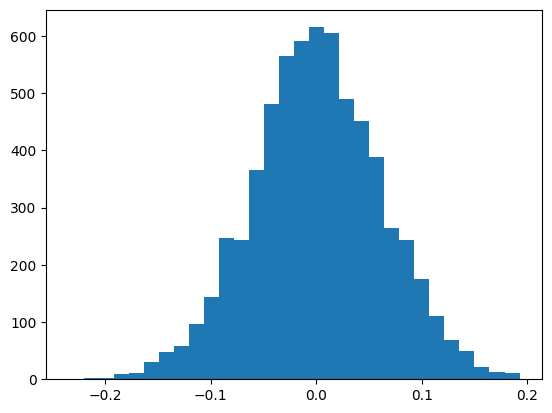

In [46]:
plt.hist(hidden.view(-1).tolist(), 30)

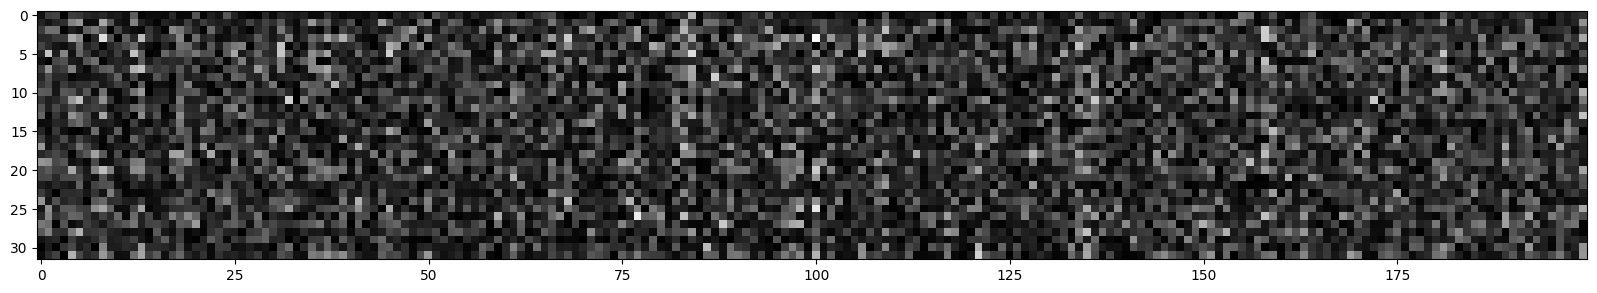

In [47]:
plt.figure(figsize=(20, 10))
plt.imshow(hidden.abs(), cmap='gray', interpolation='nearest')

In [48]:
def train_model(model_dict, n_steps, batch_size, g):
    losses = []

    for i in range(n_steps):
        X_batch, Y_batch = random_batch(X_train, Y_train, batch_size, g=g)
        nl_loss, _, _ = forward(model_dict, X_batch, Y_batch)
        lr = 0.1 if i < 10000 else 0.01
        loss_val = backprop(model_dict, nl_loss, lr=lr)
        losses.append(loss_val)
    
    return model_dict, losses


batch_size = 32
n_steps = 100000
model_dict, losses = train_model(model_dict, n_steps=n_steps, batch_size=batch_size, g=g)
print(losses[-2:])

[2.2601003646850586, 1.9938442707061768]


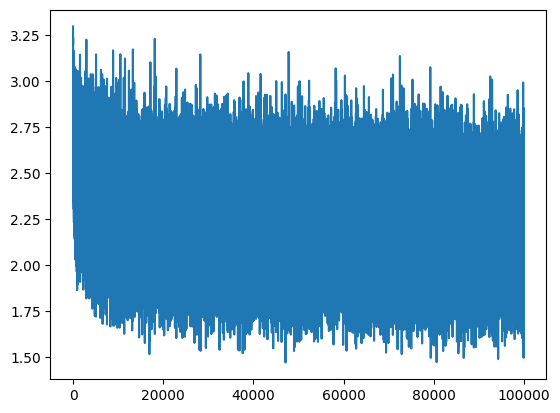

In [49]:
plt.plot(losses)

train 2.1817564964294434


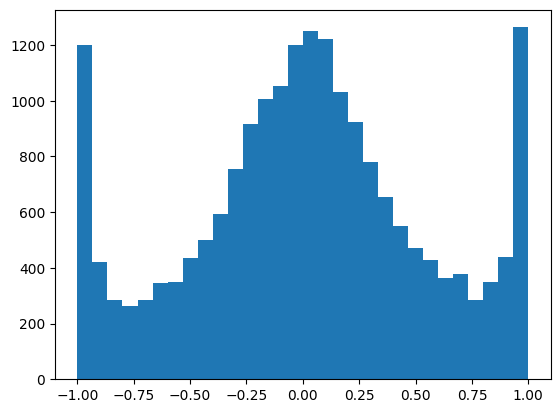

In [50]:
@torch.no_grad()
def split_loss(model_dict, datasets, data_name):
    x, y = datasets[data_name]
    loss, hidden, _ = forward(model_dict, x, y)
    print(data_name, loss.item())
    plt.hist(hidden[:100].view(-1).tolist(), 30)

split_loss(model_dict, datasets, data_name='train')

val 2.1944339275360107


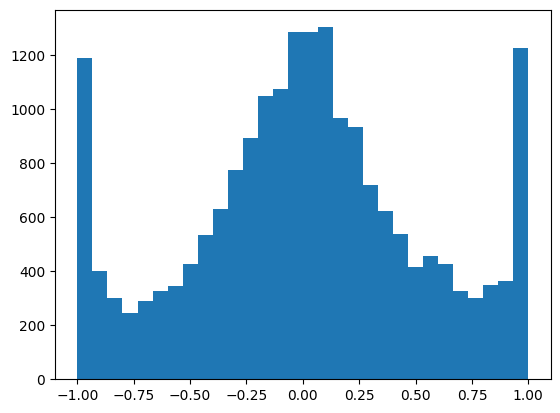

In [51]:
split_loss(model_dict, datasets, data_name='val')

# playing with STD

tensor(-0.0103) tensor(0.9973)
tensor(0.0039) tensor(3.1723)


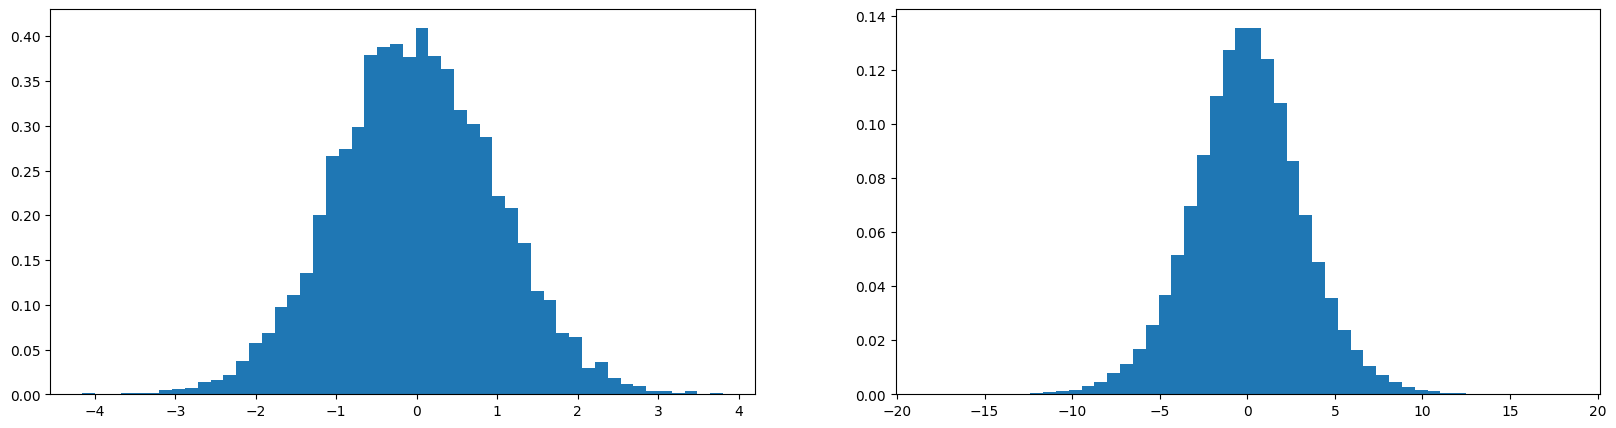

In [52]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.show()


tensor(-0.0057) tensor(0.9965)
tensor(0.0009) tensor(0.9926)


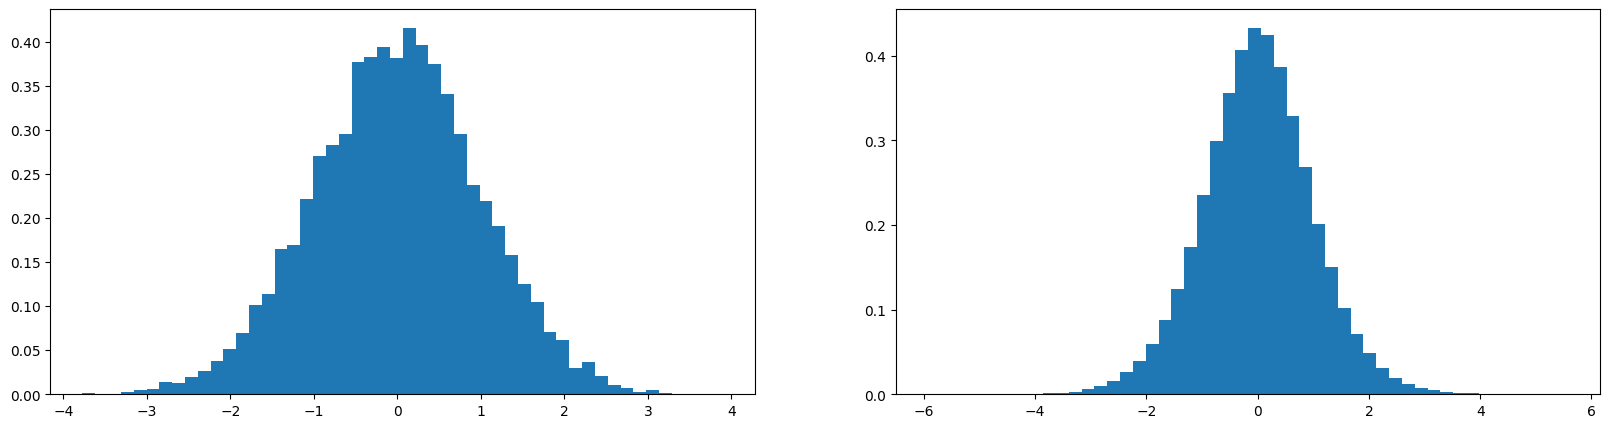

In [53]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / (10**0.5)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.show()


In [54]:
def init_model(vocab_size, block_size, embedding_size, hidden_size, g):
    C = torch.randn((vocab_size, embedding_size), generator=g)
    W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g) * (5.0/3.0) / ((block_size * embedding_size)**0.5)
    b1 = torch.randn((1, hidden_size), generator=g) * 0.01
    W2 = torch.randn((hidden_size, vocab_size), generator=g) * 0.01
    b2 = torch.randn((1, vocab_size), generator=g) * 0.0

    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True

    return {
        "C": C,
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "parameters": parameters
    }

In [55]:
def train_model(model_dict, n_steps, batch_size, g):
    losses = []

    for i in range(n_steps):
        X_batch, Y_batch = random_batch(X_train, Y_train, batch_size, g=g)
        nl_loss, _, _ = forward(model_dict, X_batch, Y_batch)
        lr = 0.1 if i < 10000 else 0.01
        loss_val = backprop(model_dict, nl_loss, lr=lr)
        losses.append(loss_val)
    
    return model_dict, losses


batch_size = 32
n_steps = 100000
model_dict = init_model(vocab_size, block_size, embedding_size, hidden_size, g)
model_dict, losses = train_model(model_dict, n_steps=n_steps, batch_size=batch_size, g=g)
print(losses[-2:])

[1.9830061197280884, 2.118952989578247]


val 2.1387884616851807


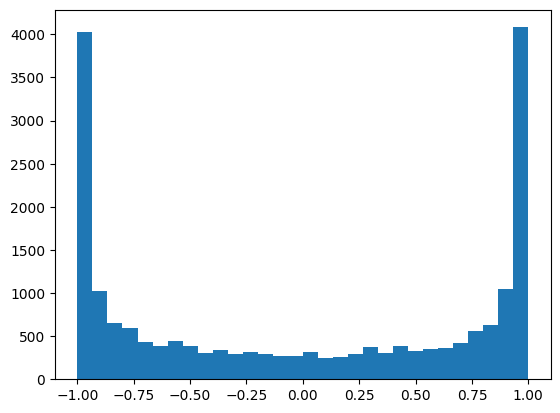

In [56]:
split_loss(model_dict, datasets, data_name='val')

# Batch Norm

In [60]:
def init_model(vocab_size, block_size, embedding_size, hidden_size, g):
    C = torch.randn((vocab_size, embedding_size), generator=g)
    W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g) * (5.0/3.0) / ((block_size * embedding_size)**0.5)
    b1 = torch.randn((1, hidden_size), generator=g) * 0.01
    W2 = torch.randn((hidden_size, vocab_size), generator=g) * 0.01
    b2 = torch.randn((1, vocab_size), generator=g) * 0.0

    bn_gain = torch.ones((1, hidden_size))
    bn_bias = torch.zeros((1, hidden_size))

    parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
    for p in parameters:
        p.requires_grad = True

    return {
        "C": C,
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "bn_gain": bn_gain,
        "bn_bias": bn_bias,
        "parameters": parameters
    }

def forward(model_dict, X_batch, Y_batch):
    C, W1, b1, W2, b2, bn_gain, bn_bias = (
        model_dict["C"], model_dict["W1"], model_dict["b1"], model_dict["W2"], model_dict["b2"],
        model_dict["bn_gain"], model_dict["bn_bias"]
    )
    embedded = C[X_batch]
    Z = embedded.view(-1, W1.size(0)) @ W1 + b1
    m, std = Z.mean(dim=0, keepdim=True), Z.std(dim=0, keepdim=True)
    Z = bn_gain * (Z - m) / std + bn_bias
    hidden = torch.tanh(Z)
    logits = hidden @ W2 + b2
    nl_loss = F.cross_entropy(logits, Y_batch)
    return nl_loss, hidden.detach(), logits.detach()


In [61]:
def train_model(model_dict, n_steps, batch_size, g):
    losses = []

    for i in range(n_steps):
        X_batch, Y_batch = random_batch(X_train, Y_train, batch_size, g=g)
        nl_loss, _, _ = forward(model_dict, X_batch, Y_batch)
        lr = 0.1 if i < 10000 else 0.01
        loss_val = backprop(model_dict, nl_loss, lr=lr)
        losses.append(loss_val)
    
    return model_dict, losses


batch_size = 32
n_steps = 100000
model_dict = init_model(vocab_size, block_size, embedding_size, hidden_size, g)
model_dict, losses = train_model(model_dict, n_steps=n_steps, batch_size=batch_size, g=g)
print(losses[-2:])

[2.182453155517578, 2.101191997528076]


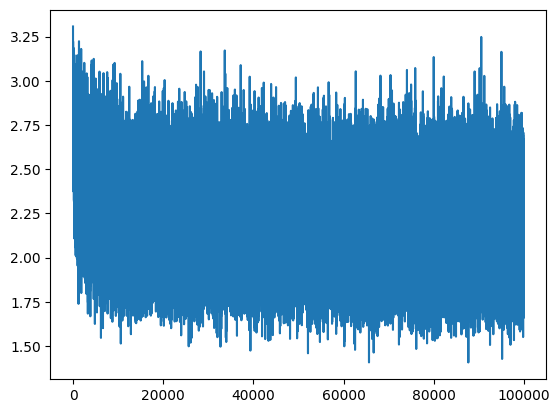

In [62]:
plt.plot(losses)

train 2.1385858058929443


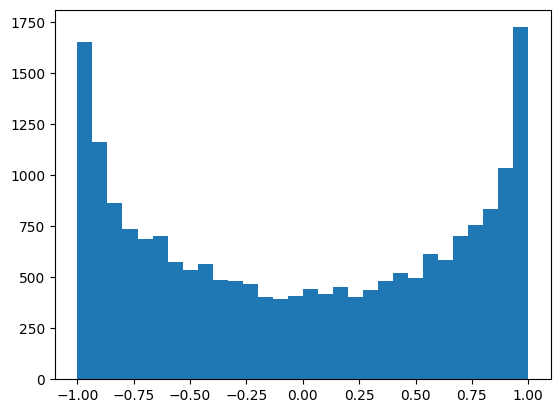

In [63]:
@torch.no_grad()
def split_loss(model_dict, datasets, data_name):
    x, y = datasets[data_name]
    loss, hidden, _ = forward(model_dict, x, y)
    print(data_name, loss.item())
    plt.hist(hidden[:100].view(-1).tolist(), 30)

split_loss(model_dict, datasets, data_name='train')

val 2.16571307182312


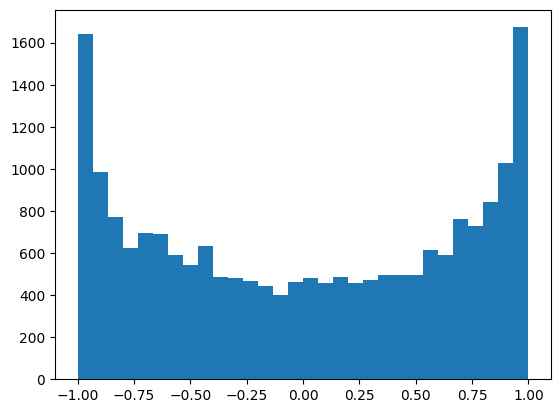

In [64]:
split_loss(model_dict, datasets, data_name='val')

## Estimation of batch-norm mean/std from training

In [86]:
def init_model(vocab_size, block_size, embedding_size, hidden_size, g):
    C = torch.randn((vocab_size, embedding_size), generator=g)
    W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g) * (5.0/3.0) / ((block_size * embedding_size)**0.5)
    # b1 = torch.randn((1, hidden_size), generator=g) * 0.01
    W2 = torch.randn((hidden_size, vocab_size), generator=g) * 0.01
    b2 = torch.randn((1, vocab_size), generator=g) * 0.0

    bn_gain = torch.ones((1, hidden_size))
    bn_bias = torch.zeros((1, hidden_size))

    bn_mean = torch.zeros((1, hidden_size))
    bn_std = torch.ones((1, hidden_size))

    parameters = [C, W1, W2, b2, bn_gain, bn_bias] #, b1
    for p in parameters:
        p.requires_grad = True

    return {
        "C": C,
        "W1": W1,
        # "b1": b1,
        "W2": W2,
        "b2": b2,
        "bn_gain": bn_gain,
        "bn_bias": bn_bias,
        "bn_mean": bn_mean,
        "bn_std": bn_std,
        "parameters": parameters
    }

def forward(model_dict, X_batch, Y_batch, eval=False):
    C, W1, W2, b2, bn_gain, bn_bias, bn_mean, bn_std = ( #, b1
        model_dict["C"], model_dict["W1"], model_dict["W2"], model_dict["b2"], #, model_dict["b1"]
        model_dict["bn_gain"], model_dict["bn_bias"], model_dict["bn_mean"], model_dict["bn_std"]
    )
    embedded = C[X_batch]
    Z = embedded.view(-1, W1.size(0)) @ W1 # + b1
    if not eval:
        batch_m, batch_std = Z.mean(dim=0, keepdim=True), Z.std(dim=0, keepdim=True)
        with torch.no_grad():
            model_dict["bn_mean"] = bn_mean * 0.999 + batch_m * 0.001
            model_dict["bn_std"] = bn_std * 0.999 + batch_std * 0.001
    else:
        batch_m, batch_std = bn_mean, bn_std
    Z = bn_gain * (Z - batch_m) / batch_std + bn_bias
    hidden = torch.tanh(Z)
    logits = hidden @ W2 + b2
    nl_loss = F.cross_entropy(logits, Y_batch) if Y_batch is not None else None
    return nl_loss, hidden.detach(), logits.detach()


In [87]:
def train_model(model_dict, n_steps, batch_size, g):
    losses = []

    for i in range(n_steps):
        X_batch, Y_batch = random_batch(X_train, Y_train, batch_size, g=g)
        nl_loss, _, _ = forward(model_dict, X_batch, Y_batch)
        lr = 0.1 if i < 10000 else 0.01
        loss_val = backprop(model_dict, nl_loss, lr=lr)
        losses.append(loss_val)
    
    return model_dict, losses


batch_size = 32
n_steps = 100000
model_dict = init_model(vocab_size, block_size, embedding_size, hidden_size, g)
model_dict, losses = train_model(model_dict, n_steps=n_steps, batch_size=batch_size, g=g)
print(losses[-2:])

[2.423088550567627, 1.8802690505981445]


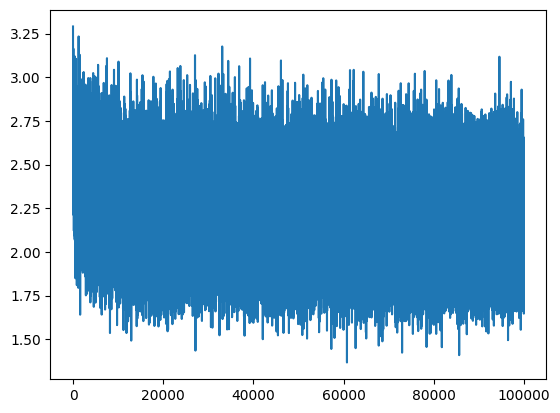

In [88]:
plt.plot(losses)

train 2.14290452003479


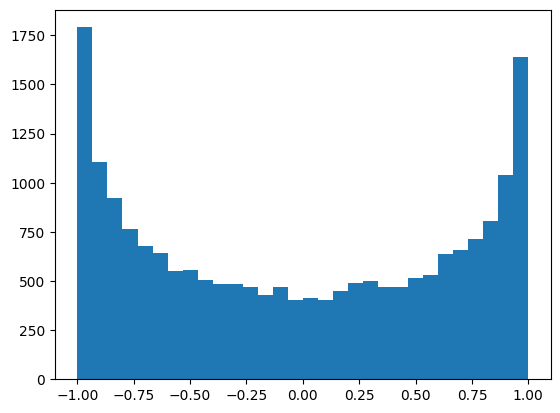

In [89]:
@torch.no_grad()
def split_loss(model_dict, datasets, data_name):
    x, y = datasets[data_name]
    loss, hidden, _ = forward(model_dict, x, y, eval=True)
    print(data_name, loss.item())
    plt.hist(hidden[:100].view(-1).tolist(), 30)

split_loss(model_dict, datasets, data_name='train')

val 2.1651086807250977


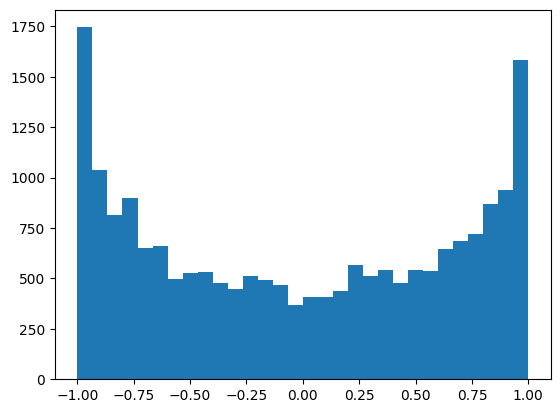

In [90]:
split_loss(model_dict, datasets, data_name='val')

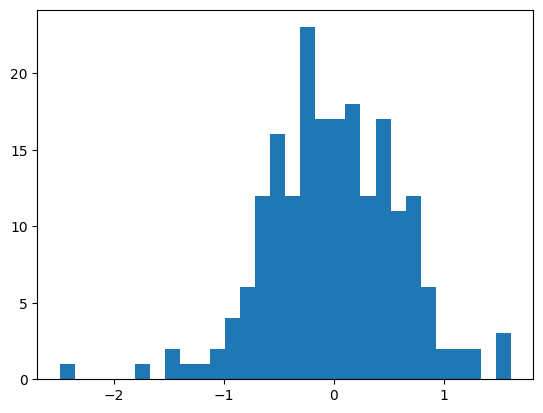

In [91]:
plt.hist(model_dict["bn_mean"].view(-1).tolist(), 30)
plt.show()

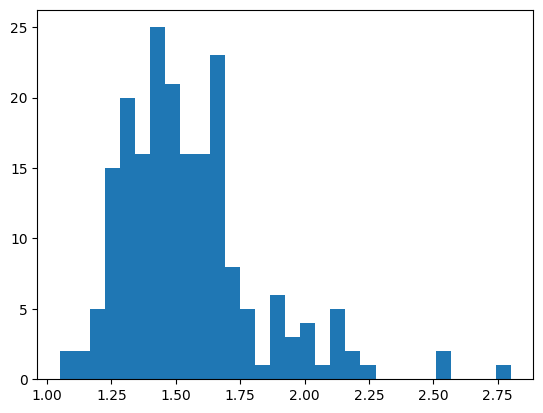

In [92]:
plt.hist(model_dict["bn_std"].view(-1).tolist(), 30)
plt.show()

# Pytorch styled

In [106]:
class Embedding:

    def __init__(self, in_classes, emb_size) -> None:
        self.C = torch.randn((in_classes, emb_size), generator=g)

    def __call__(self, x):
        self.output = self.C[x]
        return self.output
    
    def parameters(self):
        return [self.C]

class Linear:

    def __init__(self, in_features, out_features, bias=True) -> None:
        self.weight = torch.randn((in_features, out_features), generator=g) / (in_features**0.5)
        self.bias = torch.zeros(out_features) if bias else None

    def __call__(self, x):
        self.output = x.view(-1, self.weight.size(0)) @ self.weight
        if self.bias is not None:
            self.output += self.bias
        return self.output
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [107]:
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True, unbiased=True)
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.output = self.gamma * xhat + self.beta
        return self.output
    
    def parameters(self):
        return [self.gamma, self.beta]


In [108]:
class Tanh:

    def __call__(self, x):
        self.output = F.tanh(x)
        return self.output
    
    def parameters(self):
        return []

In [144]:
def init_layers():
    vocab_size = len(index2letter)
    embedding_size = 10
    hidden_size = 100
    block_size = 3

    model_layers = [
        Embedding(vocab_size, embedding_size),
        Linear(block_size * embedding_size, hidden_size), Tanh(),
        Linear(hidden_size, hidden_size), Tanh(),
        Linear(hidden_size, hidden_size), Tanh(),
        Linear(hidden_size, hidden_size), Tanh(),
        Linear(hidden_size, hidden_size), Tanh(),
        Linear(hidden_size, vocab_size)
    ]

    with torch.no_grad():
        model_layers[-1].weight *= 0.1

        for layer in model_layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= 1

    parameters = [p for layer in model_layers for p in layer.parameters()]
    for p in parameters:
        p.requires_grad = True

    return model_layers, parameters

def train_layers(model_layers, parameters, n_steps, batch_size, print_every=10000):
    losses = []
    ud = []

    for i in range(n_steps):
        X_batch, Y_batch = random_batch(X_train, Y_train, batch_size, g=g)
        for layer in model_layers:
            X_batch = layer(X_batch)
        loss = F.cross_entropy(X_batch, Y_batch)

        for layer in model_layers:
            layer.output.retain_grad()
        for p in parameters:
            p.grad = None
        
        loss.backward()

        lr = 0.1 if i < 150000 else 0.01
        for p in parameters:
            p.data -= lr * p.grad

        losses.append(loss.item())
    
        if i % print_every == 0:
            print(f"{i:7d}/{n_steps:7d}: {loss.item():4f}")

        with torch.no_grad():
            ud.append([((lr * p.grad).std()/p.data.std()).log10().item() for p in parameters])

    return model_layers, losses, ud


In [145]:
g = torch.Generator().manual_seed(2147483647)
model_layers, parameters = init_layers()

model_layers, losses, ud = train_layers(model_layers, parameters, n_steps=100000, batch_size=32)

      0/ 100000: 3.295415
  10000/ 100000: 2.758944
  20000/ 100000: 2.049681
  30000/ 100000: 1.756683
  40000/ 100000: 2.117635
  50000/ 100000: 2.150456
  60000/ 100000: 1.665511
  70000/ 100000: 2.042544
  80000/ 100000: 1.994102
  90000/ 100000: 2.146353


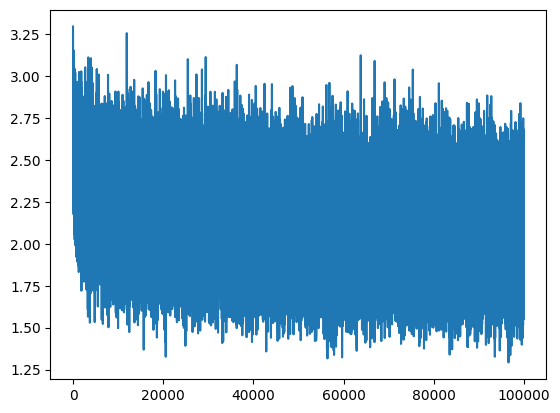

In [146]:
plt.plot(losses)
plt.show()

output layer 2 (      Tanh): mean -0.04, std 0.86, saturated 44.78%
output layer 4 (      Tanh): mean +0.03, std 0.87, saturated 49.66%
output layer 6 (      Tanh): mean +0.00, std 0.88, saturated 49.16%
output layer 8 (      Tanh): mean -0.02, std 0.88, saturated 47.72%
output layer 10 (      Tanh): mean -0.05, std 0.73, saturated 26.25%
grad layer 2 (      Tanh): mean -0.00, std 0.00, saturated 0.00%
grad layer 4 (      Tanh): mean +0.00, std 0.00, saturated 0.00%
grad layer 6 (      Tanh): mean +0.00, std 0.00, saturated 0.00%
grad layer 8 (      Tanh): mean +0.00, std 0.00, saturated 0.00%
grad layer 10 (      Tanh): mean +0.00, std 0.00, saturated 0.00%


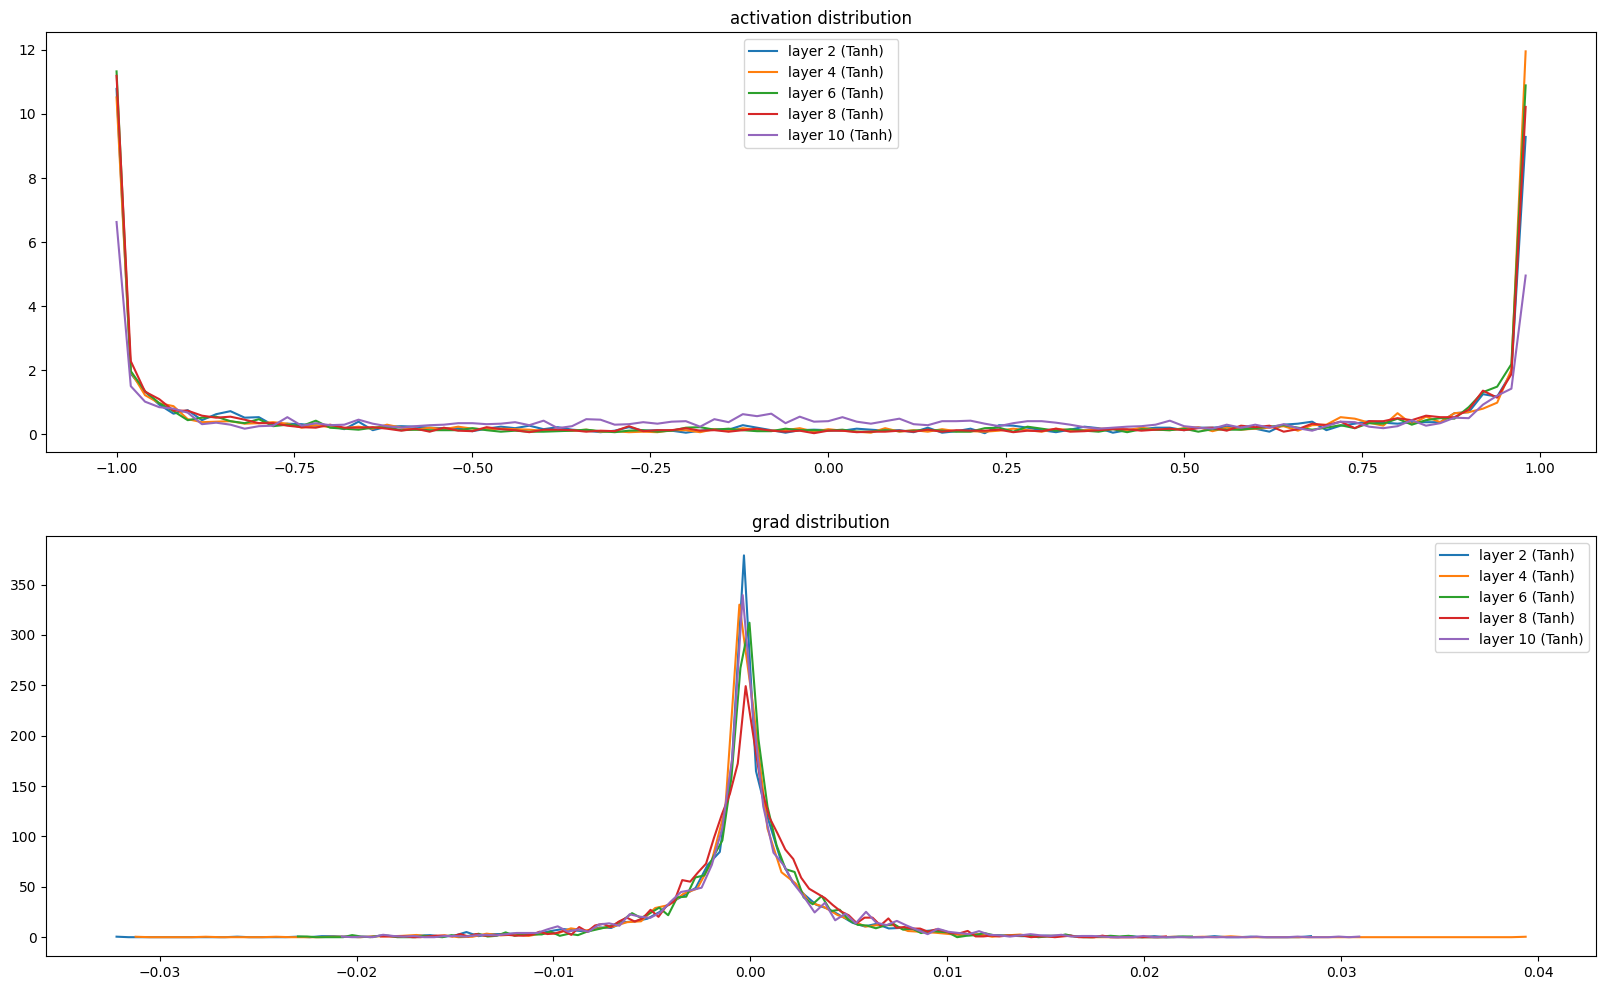

In [147]:
def plot_output_grad(model_layers):
    plt.figure(figsize=(20, 12))
    legends = []

    ax = plt.subplot(211)
    for i, layer in enumerate(model_layers):
        if isinstance(layer, Tanh):
            t = layer.output
            print("output layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f%%" %
                (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            ax.plot(hx[:-1].detach(),hy.detach())
            legends.append(f"layer {i} ({layer.__class__.__name__})")
    ax.legend(legends)
    ax.set_title("activation distribution")

    legends = []

    ax = plt.subplot(212)

    for i, layer in enumerate(model_layers):
        if isinstance(layer, Tanh):
            t = layer.output.grad
            print("grad layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f%%" %
                (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            ax.plot(hx[:-1].detach(),hy.detach())
            legends.append(f"layer {i} ({layer.__class__.__name__})")
    ax.legend(legends)
    ax.set_title("grad distribution")

    plt.show()

plot_output_grad(model_layers)

In [153]:
def plot_update_std(ud, parameters):
  plt.figure(figsize=(20, 4))
  legends = []
  for i,p in enumerate(parameters):
    if p.ndim == 2:
      plt.plot([ud[j][i] for j in range(len(ud))])
      legends.append('param %d' % i)
  plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
  plt.legend(legends);


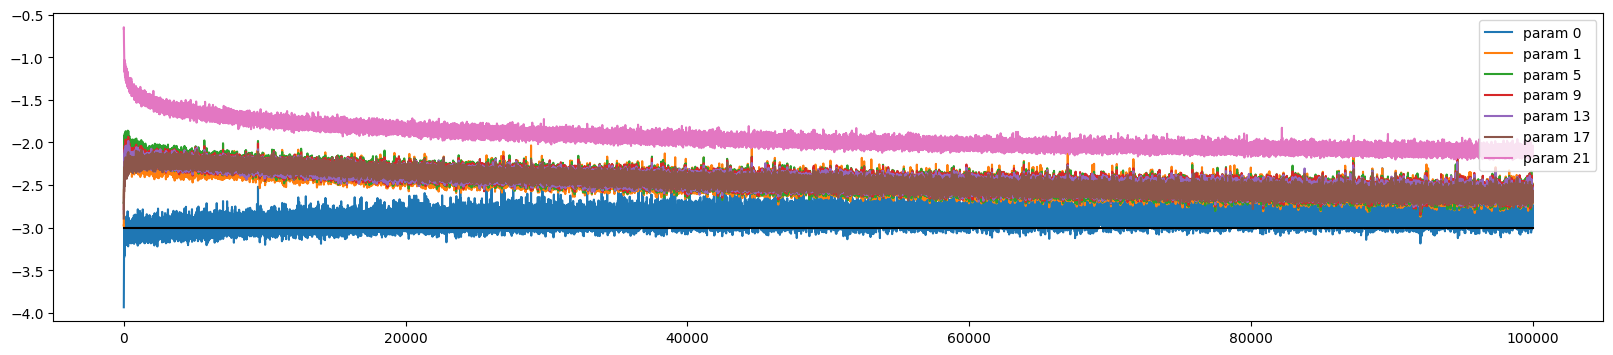

In [154]:
plot_update_std(ud, parameters)

In [163]:
def init_layers():
    vocab_size = len(index2letter)
    embedding_size = 10
    hidden_size = 100
    block_size = 3

    model_layers = [
        Embedding(vocab_size, embedding_size),
        Linear(block_size * embedding_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
        Linear(hidden_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
        Linear(hidden_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
        Linear(hidden_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
        Linear(hidden_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
        Linear(hidden_size, vocab_size, bias=False), BatchNorm1d(vocab_size)
    ]

    with torch.no_grad():
        model_layers[-1].gamma *= 0.1

        for layer in model_layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= 1

    parameters = [p for layer in model_layers for p in layer.parameters()]
    for p in parameters:
        p.requires_grad = True

    return model_layers, parameters


In [164]:
g = torch.Generator().manual_seed(2147483647)
model_layers, parameters = init_layers()

model_layers, losses, ud = train_layers(model_layers, parameters, n_steps=100000, batch_size=32)

      0/ 100000: 3.298545
  10000/ 100000: 2.848036
  20000/ 100000: 2.166186
  30000/ 100000: 1.807040
  40000/ 100000: 2.228634
  50000/ 100000: 2.064407
  60000/ 100000: 1.761118
  70000/ 100000: 2.063449
  80000/ 100000: 2.014331
  90000/ 100000: 2.084420


output layer 3 (      Tanh): mean -0.02, std 0.72, saturated 16.53%
output layer 6 (      Tanh): mean -0.02, std 0.74, saturated 18.53%
output layer 9 (      Tanh): mean +0.00, std 0.76, saturated 18.84%
output layer 12 (      Tanh): mean -0.00, std 0.77, saturated 17.59%
output layer 15 (      Tanh): mean -0.01, std 0.77, saturated 18.88%
grad layer 3 (      Tanh): mean +0.00, std 0.00, saturated 0.00%
grad layer 6 (      Tanh): mean -0.00, std 0.00, saturated 0.00%
grad layer 9 (      Tanh): mean -0.00, std 0.00, saturated 0.00%
grad layer 12 (      Tanh): mean -0.00, std 0.00, saturated 0.00%
grad layer 15 (      Tanh): mean +0.00, std 0.00, saturated 0.00%


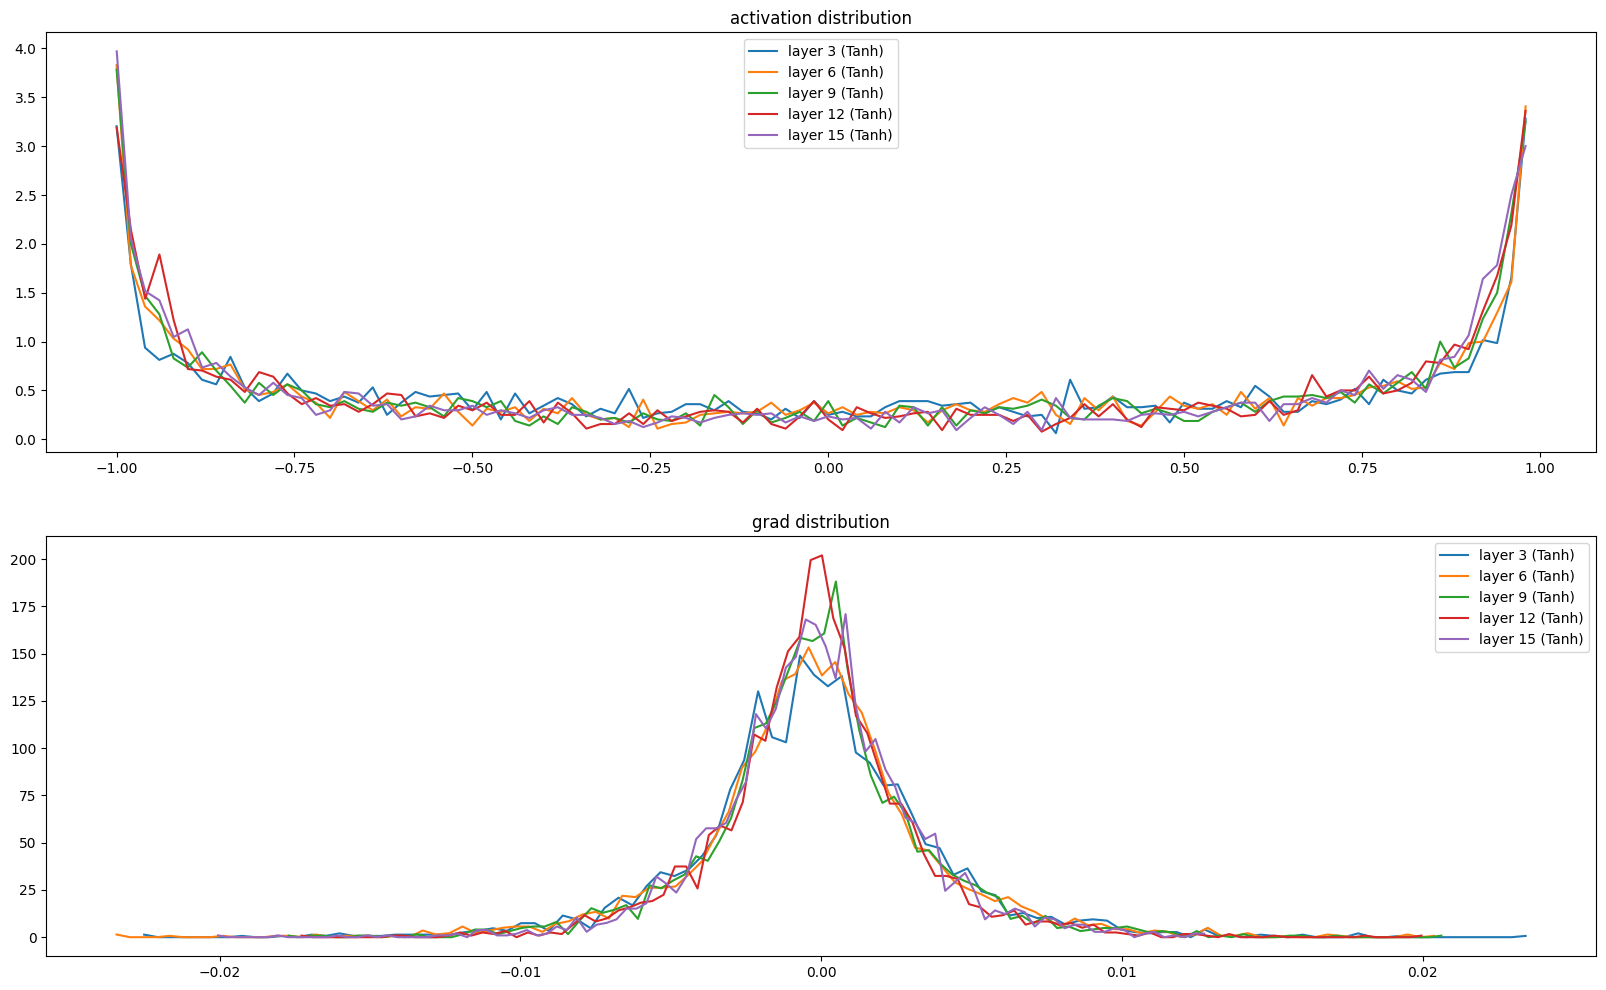

In [165]:
plot_output_grad(model_layers)

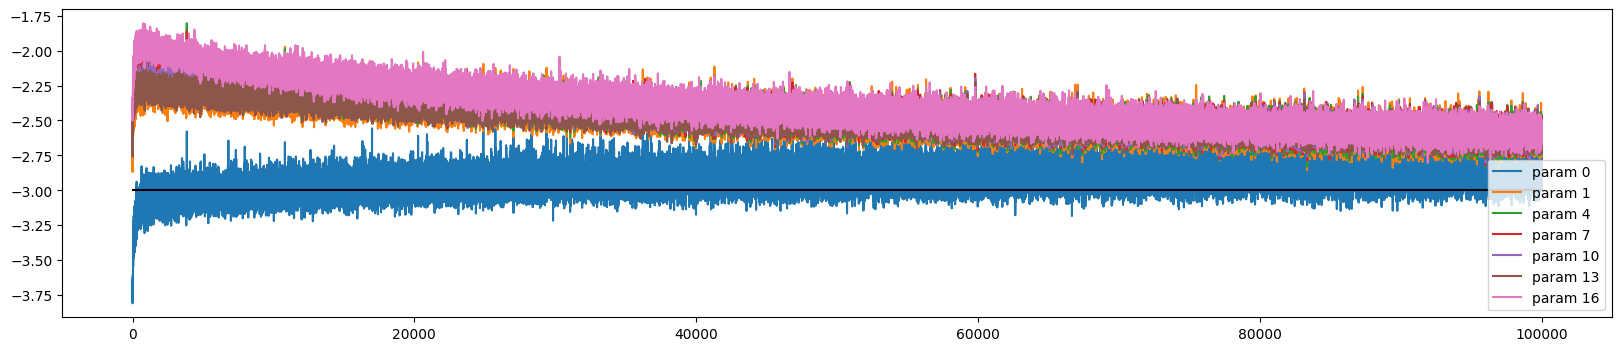

In [166]:
plot_update_std(ud, parameters)

In [167]:
@torch.no_grad()
def split_loss(model_layers, datasets, data_name):
    x, y = datasets[data_name]
    for layer in model_layers:
        layer.training = False
        x = layer(x)
    loss = F.cross_entropy(x, y)

    print(data_name, loss.item())


In [168]:
split_loss(model_layers, datasets, data_name='train')

train 2.056323766708374


In [169]:
split_loss(model_layers, datasets, data_name='val')

val 2.1114864349365234


In [170]:
@torch.no_grad()
def sampling(model_layers, n_samples=10):
    for _ in range(n_samples):
        outputs = []
        context = [letter2index[SoS]] * block_size
        while True:
            x = torch.tensor([context])
            # print(x.shape)
            for layer in model_layers:
                x = layer(x)
            logits = x
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            if index2letter[ix] == SoS:
                break
            outputs.append(index2letter[ix])
            # if len(outputs) > 20:
            #     break
        print(''.join(outputs))


In [171]:
g = torch.Generator().manual_seed(2147483647 + 10)
sampling(model_layers)

carmah
qui
harli
jaliz
taty
skanden
jazhith
delynn
jareei
nellara
